# GRU : Gated Recurrent Unit

Les Gated Recurrent Unit (GRU) sont une variante des [LSTM](python-nlp-lstm.ipynb) introduits en 2014. Ils disposent de deux portes :
* Update gate : porte de mise à jour, vecteur `z(t)`
* Reset gate : porte de réinitialisation, vecteur `r(t)` 

La porte de mise à jour est une combinaison des portes d'oubli et d'entrée des [LSTM](python-nlp-lstm.ipynb). Elle permet de définir la quantité d'information à conserver. Une autre de différence avec LSTM est que les GRU ne font pas de séparation entre l'état caché et l'état de la cellule. Ils ont également moins de paramètres à apprendre.

A l'état `t` la cellule prend en entrée les vecteurs suivants :
* `x(t)` :  représentation vectorielle de l'élément courant de la séquence
* `h(t-1)` : état caché de la cellule précédente
<img src="images/gru/gru_unit.png" />

## Porte de mise à jour 

La porte de mise à jour utilise `x(t)` et `h(t-1)` pour déterminer les informations pertinentes de `h(t-1)` à passer à l'état courant de la cellule. Une normalisation avec une fonction sigmoïde est effectuée pour obtenir un vecteur `z(t)`. Si ce vecteur est proche de «1», les informations `h(t-1)` seront transmis à `h(t)`. S'il est proche de «0», les informations du vecteur de candidat de l'état caché seront transmis à `h(t)`.

<img src="images/gru/update_gate.png" />

## Porte de réinitialisation 

La porte de réinitialisation permet de calculer le vecteur candidat pour remplacer le précédent état caché. En fonction `x(t)`, `h(t-1)` et  une fonction sigmoïde, cette porte détermine de quantifier les informations `h(t-1)` à passer à `ĥ(t)`

<img src="images/gru/reset_gate.png" />

## Etat caché de la cellule courante

Cette étape consiste à calculer :
* Le vecteur candidat `ĥ(t)` pour remplacer le précédent état caché 
* Le vecteur `h(t)`

<img src="images/gru/state_cell.png"/>

## Exemple : Modèlisation d'une série temporelle avec les GRU

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings("ignore")
sns.set()
np.random.seed(1234)
tf.random.set_seed(1234)
def prepare_data(series, size=1):
    data_X, data_Y = [], []
    m = len(series) - size - 1
    for i in range(m):
        data_X.append(series[i: (i + size)])
        data_Y.append(series[i + size])
    return np.array(data_X), np.array(data_Y)

In [2]:
data = pd.read_csv('data/airline-passengers.csv')
data.columns = data.columns.str.upper()
data.shape

(144, 2)

In [3]:
data.head()

,MONTH,PASSENGERS
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
train, test = data.iloc[:100], data.iloc[100:]
train.shape, test.shape

((100, 2), (44, 2))

In [5]:
size = 1
scaler = MinMaxScaler().fit(train[['PASSENGERS']])
train_X = scaler.transform(train[['PASSENGERS']])
test_X = scaler.transform(test[['PASSENGERS']])
train_X, train_Y = prepare_data(train_X, size)
test_X, test_Y = prepare_data(test_X, size)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [6]:
gru = keras.Sequential(
    [
        layers.GRU(16, return_sequences=True, input_shape=(1, size)),
        layers.Flatten(),
        layers.Dense(1, activation="linear")
    ]
)
gru.compile(loss="mean_squared_error", optimizer="rmsprop")
_ = gru.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=0)

In [7]:
predicted = gru.predict(test_X)
predicted = scaler.inverse_transform(predicted)

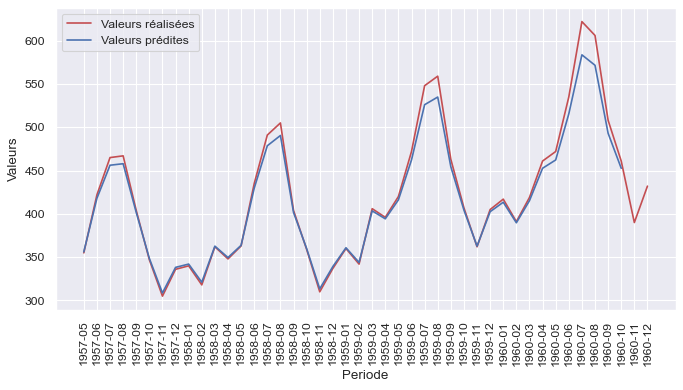

In [8]:
plt.figure(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test['PASSENGERS'].values, color="r", label="Valeurs réalisées")
plt.plot(predicted, color="b", label="Valeurs prédites")
plt.xticks(range(test.shape[0]), labels=test['MONTH'], rotation='vertical')
plt.legend()
plt.xlabel("Periode")
plt.ylabel("Valeurs")
plt.grid(True)
plt.show()

**Références :**  
[CS 224D: Deep Learning for NLP1 ](https://cs224d.stanford.edu/lecture_notes/LectureNotes4.pdf)  